In [4]:
import numpy as np
import pandas as pd
from spatial_OT.OT import *
from spatial_OT.utils import *
from scipy.spatial import distance
import numpy as np
import ot
import matplotlib.pyplot as plt

In [5]:
def process_slice(csv_path, k):
    """Load data, build k-NN graph, compute spatial entropy, and average neighbor expression."""
    print(f"Processing {csv_path}...")

    # Load CSV
    slice_data = pd.read_csv(csv_path)

    # Extract features
    expression = slice_data.iloc[:, 4:]
    locations = slice_data.iloc[:, :2]
    cells = slice_data.iloc[:, 2]
    clustered = slice_data.iloc[:, 3]

    # Build k-NN graph
    G = build_knn_graph_from2d(slice_data, k=k)

    # Compute spatial entropy
    spatial_entropies = compute_spatial_entropy(G)
    slice_data["spatial_entropy"] = slice_data.index.map(spatial_entropies)
    entropy = slice_data["spatial_entropy"]

    # Compute average neighbor expression
    average_expression = compute_average_neighbor_expression(G, expression)

    return {
        "data": slice_data,
        "expression": expression,
        "locations": locations,
        "cells": cells,
        "clustered": clustered,
        "graph": G,
        "entropy": entropy,
        "average_expression": average_expression,
    }

def compute_distance_matrices(slice1_expr, slice2_expr, slice1_loc, slice2_loc, slice1_entropy, slice2_entropy, slice1_avg, slice2_avg, G1, G2, kl_divergence=False):
    """Compute distance matrices M, C1, C2, C3, and C4."""
    
    print("Computing distance matrices...")

    M = distance.cdist(slice1_expr.values, slice2_expr.values).astype(float)
    C1 = distance.cdist(slice1_loc.values, slice1_loc.values).astype(float)
    C2 = distance.cdist(slice2_loc.values, slice2_loc.values).astype(float)

    if kl_divergence:
        C3 = compute_kl_matrix(G1, G2)
    else:
        C3 = np.abs(slice1_entropy.values[:, np.newaxis] - slice2_entropy.values[np.newaxis, :])

    C4 = distance.cdist(slice1_avg.values, slice2_avg.values).astype(float)

    return M, C1, C2, C3, C4

def normalize_matrices(*matrices):
    """Normalize matrices by their maximum value."""
    return [mat / mat.max() if mat.max() > 0 else mat for mat in matrices]

In [6]:
# Define input files
slice_paths = ["data/simulations/2D_sim_t1.csv", "data/simulations/2D_sim_t2.csv"]
k = 5

# Process both slices
slice1 = process_slice(slice_paths[0], k)
slice2 = process_slice(slice_paths[1], k)

# Compute distance matrices
M, C1, C2, C3, C4 = compute_distance_matrices(
    slice1["expression"], slice2["expression"], 
    slice1["locations"], slice2["locations"], 
    slice1["entropy"], slice2["entropy"], 
    slice1["average_expression"], slice2["average_expression"], 
    slice1["graph"], slice2["graph"], kl_divergence=False
)

# Normalize matrices
M, C1, C2, C3, C4 = normalize_matrices(M, C1, C2, C3, C4)

Processing data/simulations/2D_sim_t1.csv...
Processing data/simulations/2D_sim_t2.csv...
Computing distance matrices...


In [7]:
p = ot.unif(slice1["expression"].shape[0])
q = ot.unif(slice2["expression"].shape[0])
alpha_values = [0.1, 0.3, 0.5, 0.8, 1]
epsilon = 0.1

results = []

def run_transport(p, q, epsilon, alpha, C1, C2, M, C3=None, C4=None):
    """Compute transport map with or without additional cost matrices."""
    G0 = np.outer(p, q)
    if C3 is not None and C4 is not None:
        print(f"Computing FGW-SN with alpha={alpha}...")
        return compute_transport(G0, epsilon, alpha, C1, C2, p, q, M, C3, C4)
    else:
        print(f"Computing standard FGW with alpha={alpha}...")
        return compute_transport(G0, epsilon, alpha, C1, C2, p, q, M)

def evaluate_mapping(label_1, label_2, transport_map, name):
    """Compute mapping accuracy for given labels."""
    return mapping_accuracy(label_1.values.flatten(), label_2.values.flatten(), transport_map)

# Run for different alpha values and store results
for alpha in alpha_values:
    FGW = run_transport(p, q, epsilon, alpha, C1, C2, M)  # Standard FGW
    FGW_SN = run_transport(p, q, epsilon, alpha, C1, C2, M, C3, C4)  # FGW with spatial terms

    # Compute accuracies
    fgw_cell_acc = evaluate_mapping(slice1["cells"], slice2["cells"], FGW, "Cell Type FGW")
    fgw_clustered_acc = evaluate_mapping(slice1["clustered"], slice2["clustered"], FGW, "Clustered FGW")

    fgw_sc_cell_acc = evaluate_mapping(slice1["cells"], slice2["cells"], FGW_SN, "Cell Type FGW-SN")
    fgw_sc_clustered_acc = evaluate_mapping(slice1["clustered"], slice2["clustered"], FGW_SN, "Clustered FGW-SN")

    # Append results
    results.append({
        "alpha": alpha,
        "FGW_Cell_Acc": fgw_cell_acc,
        "FGW_Clustered_Acc": fgw_clustered_acc,
        "FGW-SN_Cell_Acc": fgw_sc_cell_acc,
        "FGW-SN_Clustered_Acc": fgw_sc_clustered_acc
    })


Computing standard FGW with alpha=0.1...
Computing FGW-SN with alpha=0.1...
Computing standard FGW with alpha=0.3...
Computing FGW-SN with alpha=0.3...
Computing standard FGW with alpha=0.5...
Computing FGW-SN with alpha=0.5...
Computing standard FGW with alpha=0.8...
Computing FGW-SN with alpha=0.8...
Computing standard FGW with alpha=1...
Computing FGW-SN with alpha=1...


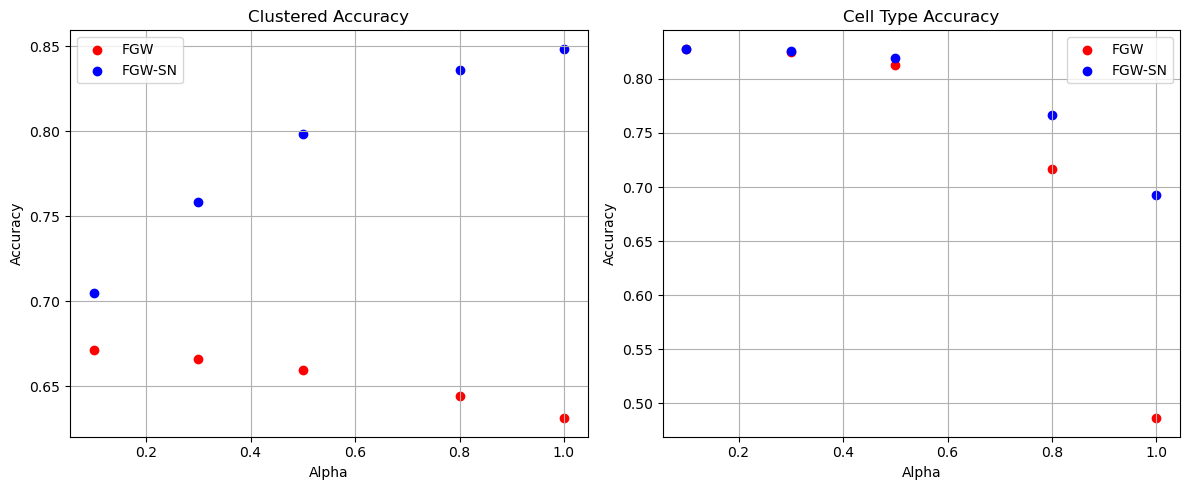

In [8]:
#FIGURE 1E

# Create a figure with two subplots
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Clustered Accuracy Plot
axes[0].scatter(results_df["alpha"], results_df["FGW_Clustered_Acc"], label="FGW", color="red")
axes[0].scatter(results_df["alpha"], results_df["FGW-SN_Clustered_Acc"], label="FGW-SN", color="blue")
axes[0].set_title("Clustered Accuracy")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Cell Type Accuracy Plot
axes[1].scatter(results_df["alpha"], results_df["FGW_Cell_Acc"], label="FGW", color="red")
axes[1].scatter(results_df["alpha"], results_df["FGW-SN_Cell_Acc"], label="FGW-SN", color="blue")
axes[1].set_title("Cell Type Accuracy")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()